<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Dielectrophoretic Particle Problem
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Dielectrophoretic Particle Problem:* This problem consists of a dielectrophoretic particle system. The goal is to find the trajectory that minimize the time taken for the particle to travel between two points.     
The problem is inspired from [Time-optimal control of a particle in a dielectrophoretic
system](https://minesparis-psl.hal.science/hal-00531113/document) by Chang, D. E., Petit, N., & Rouchon, P. (2006). IEEE Transactions on Automatic Control, 51(7), 1100-1114.
      
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)

</div>

In [1]:
import Pkg
Pkg.activate("..");
include("./utils.jl");

  Activating project at `c:\Users\hajje\Dropbox\PC\Desktop\Stage\COTS`


## 1. Solving with JuMP <a id='jump'></a>

In [2]:
using JuMP , Ipopt
import HSL_jll
include("../Problems/JuMP/particle_JMP.jl")
nh=300
ParticleJMP = dielectrophoretic_particle_JMP(;nh=nh);

set_optimizer(ParticleJMP,Ipopt.Optimizer)
set_attribute(ParticleJMP, "print_level", 5)
set_optimizer_attribute(ParticleJMP,"tol",1e-8)
set_optimizer_attribute(ParticleJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(ParticleJMP,"max_iter",1000)
set_optimizer_attribute(ParticleJMP,"mu_strategy","adaptive")
set_attribute(ParticleJMP, "hsllib", HSL_jll.libhsl_path)
set_attribute(ParticleJMP, "linear_solver", "ma57")
set_optimizer_attribute(ParticleJMP, "print_timing_statistics", "yes")

In [3]:
println("Solving...")
optimize!(ParticleJMP)
println()

# Display results
if termination_status(ParticleJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(ParticleJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(ParticleJMP) == MOI.TIME_LIMIT && has_values(ParticleJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(ParticleJMP))
println()

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     5103
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5700

Total number of variables............................:      904
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      301
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequali

In [4]:
# Retrieves values of variables
x_ = ParticleJMP[:x];
y = ParticleJMP[:y];

con_x = ParticleJMP[:con_x];
con_y = ParticleJMP[:con_y];

tf = ParticleJMP[:tf];
Δtt = value.(tf)/nh;
t = Vector((0:nh)*Δtt); 

p = - [[ dual(con_x[i]), dual(con_y[i])] for i in 1:nh];
p = costateInterpolation(p, t);

x_ = Vector(value.(x_)) ;
y = Vector(value.(y)) ;

x =  [ [ x_[i], y[i]] for i in 1:nh+1];

u = Vector(value.(ParticleJMP[:u])) ;

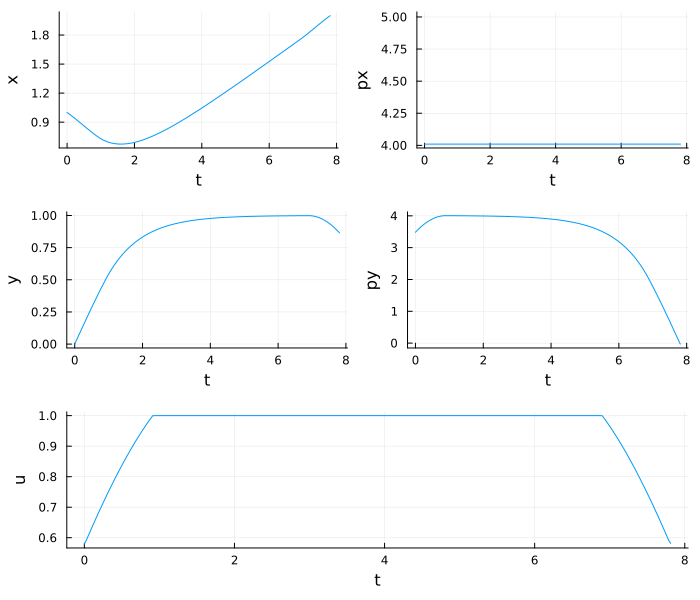

In [5]:
using Plots

x_plot = plot(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "x", legend = false)
y_plot = plot(t, [ x[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "y", legend = false)
px_plot = plot(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "px", legend = false)
py_plot = plot(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "py", legend = false)
u_plot = plot(t, [ u[i] for i in 1:nh+1 ], xlabel = "t", ylabel = "u", legend = false)

layout = @layout [a b; c d; g]

x_plot = plot(x_plot, px_plot, y_plot, py_plot, u_plot, layout = layout)
x_plot = plot!(x_plot, size = (700, 600))
display(x_plot)

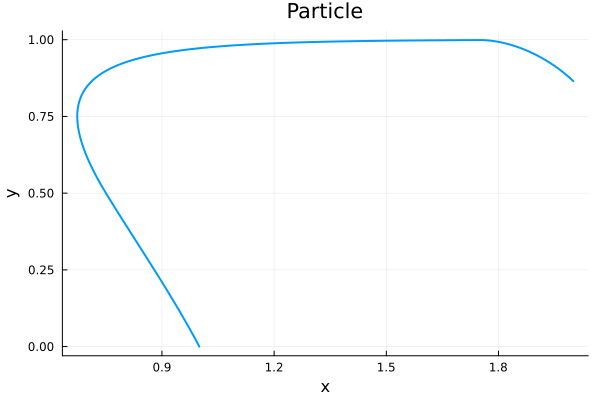

In [6]:
plot(
    x_,
    y;
    linewidth = 2,
    legend = nothing,
    title = "Particle",
    xlabel = "x",
    ylabel = "y",
)

## 2. Solving with OptimalControl <a id='oc'></a>

In [7]:
using OptimalControl
using NLPModelsIpopt
include("../Problems/OptimalControl/particle_OC.jl")
ParticleOC = dielectrophoretic_particle_OC();

In [8]:
init = dielectrophoretic_particle_init(;nh=nh-1)

(state = [1.0, 1.0], control = 0.0, variable = 1.0)

In [9]:
import HSL_jll
# Solve the problem
sol = OptimalControl.solve(ParticleOC,init=init, grid_size=nh-1,
            linear_solver="ma57",hsllib=HSL_jll.libhsl_path, print_timing_statistics="yes")

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     3591
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1200

Total number of variables............................:      901
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      601
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 1.00e+00 0.00e+00   0.0 0.00e

CTBase.OptimalControlSolution

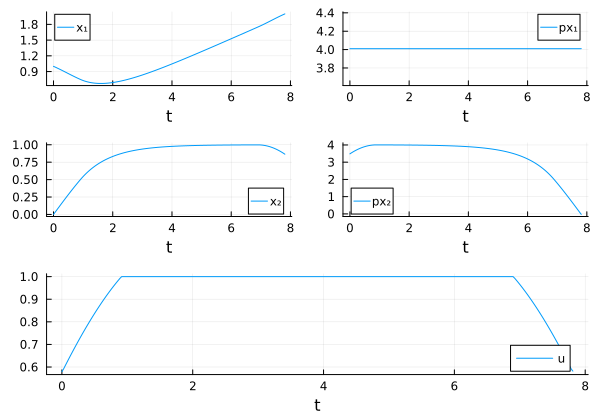

In [10]:
plot(sol)

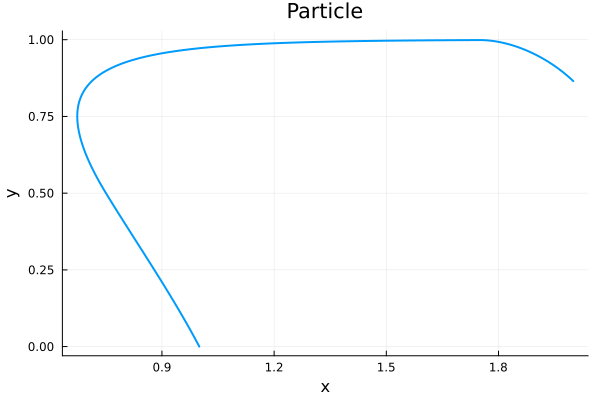

In [11]:
using JuMP
t_f = sol.variable
Δt = ones(nh)*(t_f/(nh))
ts = cumsum([0; value.(Δt)])[1:end]
xOC = [sol.state(t) for t in ts]
pos_x = [xOC[i][1] for i in 1:length(x)]
pos_y = [xOC[i][2] for i in 1:length(x)]
plot(
    pos_x,
    pos_y;
    linewidth = 2,
    legend = nothing,
    title = "Particle",
    xlabel = "x",
    ylabel = "y",
)

## 3. Comparison <a id='comp'></a>

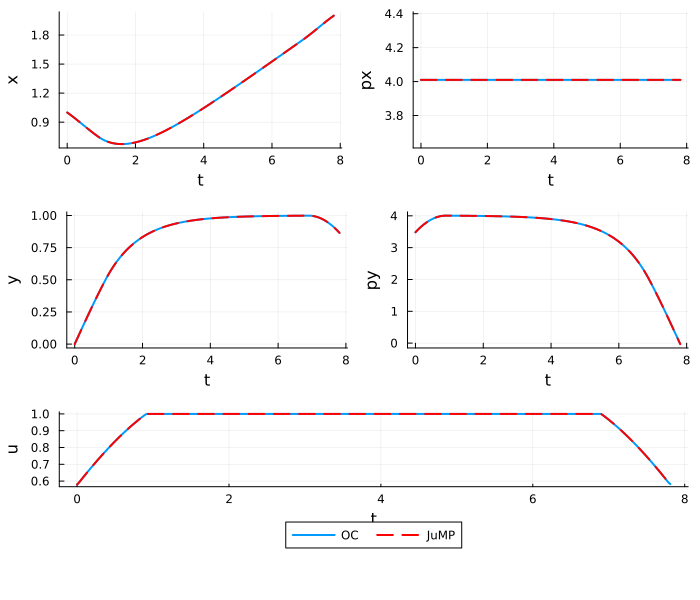

In [12]:
using Plots
px = plot(plot(sol)[1],line = 2)
px = plot!(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "x", legend = false,line = 2, color = "red",linestyle=:dash)

py = plot(plot(sol)[2],line = 2)
py = plot!(t, [ x[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "y", legend = false,line = 2, color = "red",linestyle=:dash)

ppx = plot(plot(sol)[3],line = 2)
ppx = plot!(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "px", legend = false,line = 2, color = "red",linestyle=:dash)

ppy = plot(plot(sol)[4],line = 2)
ppy = plot!(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "py", legend = false,line = 2, color = "red",linestyle=:dash)

p9 = plot(plot(sol)[5] , label ="OC",line = 2)
p9 = plot!(t, [u[i] for i in 1:nh+1 ], xlabel = "t", ylabel = "u", legend = false, label = "JuMP",line = 2, color = "red",linestyle=:dash)
p9 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [a b; c d; k]
x_plot = plot(px, ppx, py, ppy, p9, layout = layout, size = (700, 600))

display(x_plot)
